In [0]:
%pip install saspy

Python interpreter will be restarted.
Requirement already satisfied: saspy in /databricks/python3/lib/python3.8/site-packages (4.2.0)
WARNING: You are using pip version 21.0.1; however, version 22.0.4 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-4c997663-4537-470b-ad87-99a4093f2eb1/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
import saspy
import mlflow
import mlflow.pyfunc
from mlflow.utils.environment import _mlflow_conda_env
from mlflow.models.signature import infer_signature
from pyspark.sql import DataFrame

In [0]:
#interface for keeping SAS models in MLFlow
class SASModelInterface(mlflow.pyfunc.PythonModel):
  def __init__(self,  **kwargs):
    pass

  def predict(self, context, model_input) -> DataFrame:
    pass
  
  def fit(train_input):
    pass

In [0]:
#Prepare a data set obtain one from our SAS Environment
sas = saspy.SASsession( cfgfile = '/databricks/sasconfig/sascfg_personal.py',
                       cfgname='ssh_sas',
                       display='databricks'
                      )
def dbDISPLAY(x):
  displayHTML(x)
      
sas.DISPLAY = dbDISPLAY
model_df = sas.sd2df(table='baseball', libref='sashelp', method = 'MEMORY') 

/databricks/python/lib/python3.8/site-packages/saspy/sasiostdio.py:994: UserWarning: Noticed 'ERROR:' in LOG, you ought to take a look and see if there was a problem
 warnings.warn("Noticed 'ERROR:' in LOG, you ought to take a look and see if there was a problem")
SAS Connection established. Subprocess id is 1384

In [0]:
# Class Holds a Regression Model 
class SASModelSimpleRegression(SASModelInterface):
  
  def __init__(self, name,out_predict_var,in_vars):
    self.name = name
    self.in_vars = in_vars
    self.out_predict_var = out_predict_var
    
    self.model_params_dict = {}
    self.model_score_dict = {}
    self.results = []
    
   
  # main method
  def predict(self, context, model_input):
    sas = saspy.SASsession( cfgfile = '/databricks/sasconfig/sascfg_personal.py',
                       cfgname='ssh_sas'
                      )

    # upload model input into SAS Environment
    c = sas.submitLST("""LIBNAME test BASE "/opt/sas/sasdata";""")
    sas_tbl = sas.df2sd(df=model_input, table = 'model_input', libref='test')
    

    # Submit SAS Statement for a Regression Model

    self.results = sas.submit(""" 
    
             proc reg data=test.model_input outest=parmest tableout;
                  model {} = {};
                     output out=pred p=p;
            quit;
            
          """.format(self.out_predict_var,self.in_vars))
    

    # Download Model Output and Params
    model_output = sas.sd2df(table='pred', libref='WORK', method = 'MEMORY') 
    model_params = sas.sd2df(table='parmest', libref='WORK', method = 'MEMORY') 
  
    #get model params and scores
    self.getmodelparamsandscores(model_params)

    return model_input

  # retrieve model params and scores  
  def getmodelparamsandscores(self, model_params):    
    
    # get only row with params
    param_row = model_params[model_params["_TYPE_"]=="PARMS"]
    
    #display(param_row)
    # Get Column Weights 
    self.model_params_dict = param_row[param_row.columns[5:]].to_dict('records')[0]

    # GET RMSE
    self.model_score_dict = param_row[["_RMSE_"]].to_dict('records')[0]

/databricks/python/lib/python3.8/site-packages/saspy/sasiostdio.py:994: UserWarning: Noticed 'ERROR:' in LOG, you ought to take a look and see if there was a problem
 warnings.warn("Noticed 'ERROR:' in LOG, you ought to take a look and see if there was a problem")
SAS Connection established. Subprocess id is 1401

<IPython.core.display.HTML object>

<!DOCTYPE html>
 
 
 
 
 SAS Output 

 
 
 
 
 The SAS System 
 
 
 The REG Procedure 
 Model: MODEL1 
 Dependent Variable: logSalary 
 
 
 
 
 
 
 
 
 
 
 Number of Observations Read 
 322 
 
 
 Number of Observations Used 
 263 
 
 
 Number of Observations with Missing Values 
 59 
 
 
 
 
 
 
 
 
 
 
 Analysis of Variance 
 
 
 Source 
 DF 
 Sum of Squares 
 Mean Square 
 F Value 
 Pr > F 
 
 
 
 
 Model 
 6 
 121.44322 
 20.24054 
 60.45 
 <.0001 
 
 
 Error 
 256 
 85.71051 
 0.33481 
   
   
 
 
 Corrected Total 
 262 
 207.15373 
   
   
   
 
 
 
 
 
 
 
 
 
 
 Root MSE 
 0.57862 
 R-Square 
 0.5862 
 
 
 Dependent Mean 
 5.92722 
 Adj R-Sq 
 0.5765 
 
 
 Coeff Var 
 9.76216 
   
   
 
 
 
 
 
 
 
 
 
 
 Parameter Estimates 
 
 
 Variable 
 DF 
 Parameter Estimate 
 Standard Error 
 t Value 
 Pr > |t| 
 
 
 
 
 Intercept 
 1 
 4.08467 
 0.12673 
 32.23 
 <.0001 
 
 
 nHits 
 1 
 0.00834 
 0.00106 
 7.89 
 <.0001 
 
 
 nAssts 
 1 
 -0.00007772 
 0.00036021 
 -0.22 
 0.8293 
 
 
 nError 
 1 
 -0.00698 
 0.00774 
 -0.90 
 0.3680 
 
 
 nBB 
 1 
 0.00663 
 0.00215 
 3.08 
 0.0023 
 
 
 YrMajor 
 1 
 0.09424 
 0.01111 
 8.48 
 <.0001 
 
 
 CrHome 
 1 
 0.00039512 
 0.00066649 
 0.59 
 0.5538 
 
 
 
 
 
 
 
 
 The SAS System 
 
 
 The REG Procedure 
 Model: MODEL1 
 Dependent Variable: logSalary
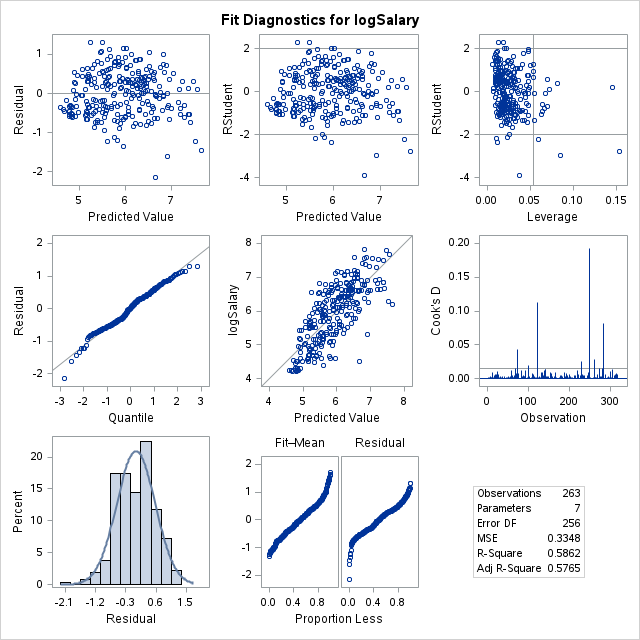
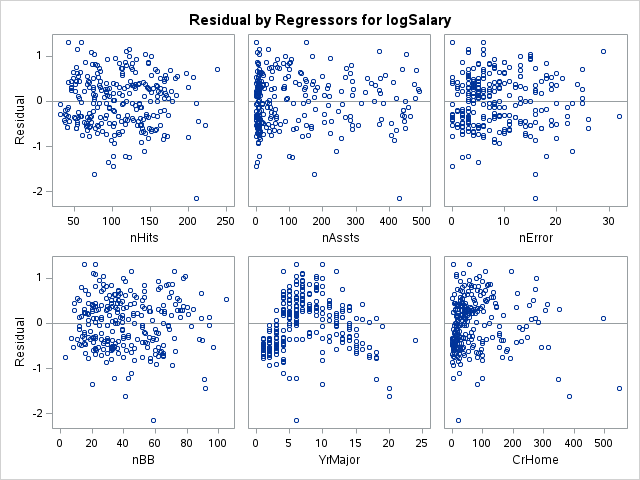

In [0]:
import mlflow

# Access these runs using the Experiment sidebar. Click Experiment at the upper right of this screen. 
with mlflow.start_run():
  
  # define a subset of columns for reg model
  #in_vars = "nHits nBB YrMajor"
  in_vars = "nHits nAssts nError nBB YrMajor CrHome"
  
  # define predict target
  out_predict_var = "logsalary"
  
  # create model
  #sas_sr_model = SASModelSimpleRegression("Simple SAS Regression",in_vars=in_vars,out_predict_var=out_predict_var)
  sas_sr_model = SASModelSimpleRegression(name = "Simple SAS Regression",in_vars = in_vars,out_predict_var=out_predict_var)
  
  # run model
  predictions_out = sas_sr_model.predict(context="", model_input=model_df)
  
  
  # log mlflow params
  mlflow.log_param("in_vars", in_vars)
  for k,v in sas_sr_model.model_params_dict.items():
    mlflow.log_param(k, v)
  #log metrics
  for k,v in sas_sr_model.model_score_dict.items():
    mlflow.log_metric(k, v)
  
  # log sas html summary
  import os
  f = open("sas_summary.html", "w+")
  f.write(sas_sr_model.results['LST'])
  f.close()
  mlflow.log_artifact("sas_summary.html")
  
  
 # print (sas_sr_model.results['LOG'])
  
  signature = infer_signature(model_df, predictions_out)
        
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
       # additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None
    )
        
  mlflow.pyfunc.log_model("SAS_Model_Simple_Regression" , python_model=sas_sr_model, conda_env=conda_env, signature=signature)   

  # display output from SAS
  displayHTML(sas_sr_model.results['LST'])